In [3]:
%load_ext autoreload
%autoreload 2

import openpyxl as pxl
import numpy as np
import matplotlib.pyplot as plt
from  colors_utils import *
from tqdm import trange
import pickle
import os
from datetime import datetime, timezone


In [4]:
def get_latest_calibration_sheet(workbook):
    """Retourne la feuille de calibration la plus récente en fonction des dates."""
    date_sheets = []
    for sheet in workbook.sheetnames:
        if sheet[:8].isdigit():  # Vérifie si les 8 premiers caractères sont des chiffres
            date_sheets.append(int(sheet[:8]))  # Convertit en entier pour comparaison
    return str(max(date_sheets)) if date_sheets else None


def charge_calibration(path, all_LEDs=['Violet', 'Blue', 'Green', 'Yellow', 'Red'], verbose=True):
    """Charge la calibration et applique les corrections basées sur les mesures utilisateur."""

    print('\nC O R R E C T I O N \n')

    correction = {color: None for color in all_LEDs}
    for color in all_LEDs:
        temp_corr = input(f'Enter the measured power of the {color} LED at 5V (mW): ')
        try:
            correction[color] = float(temp_corr)
            print(f'The {color} LED power function will be corrected.')
        except ValueError:
            print(f'No correction will be applied to the {color} LED.')

    print('\nF I L T E R S \n')

    filters = {color: 1 for color in all_LEDs}
    for color in all_LEDs:
        temp_filter = input(f'Enter the filter transmittance value applied to the {color} LED: ')
        try:
            filters[color] = float(temp_filter)
            print(f'The {color} LED will be filtered.')
        except ValueError:
            print(f'No filter will be applied to the {color} LED.')

    all_LEDs = np.flip(all_LEDs)
    
    wb = pxl.load_workbook(path)
    calibration_date = get_latest_calibration_sheet(wb)
    print(f"Using calibration sheet {calibration_date}...")
    if not calibration_date:
        raise ValueError("Aucune feuille de calibration valide trouvée dans le fichier.")

    ws = wb[calibration_date]

    fiber_to_mea_red = {color: 1 for color in all_LEDs}

    calibrations = {'voltages': np.array([ws.cell(row=i, column=1).value for i in range(4, 21)])}
    for col_i, color_name in enumerate(all_LEDs):
        temp_ratio = ws.cell(row=23, column=2 + col_i).value / ws.cell(row=20, column=2 + col_i).value
        fiber_to_mea_red[color_name] = temp_ratio
        
        calibrations[color_name] = np.array([ws.cell(row=i, column=2 + col_i).value for i in range(4, 21)])
        if correction[color_name] is not None:
            calibrations[color_name] *= correction[color_name] / calibrations[color_name][-1]
    
        calibrations[color_name] *= filters[color_name] * fiber_to_mea_red[color_name]

    min_pow, ind, old_pow = 0, 1, calibrations[all_LEDs[0]][1]
    while min_pow == 0 and ind < len(calibrations['voltages']):
        for color in all_LEDs:
            temp_pow = calibrations[color][ind]
            min_pow = min(temp_pow, old_pow)
            old_pow = temp_pow
        ind += 1

    if ind >= 1:
        calibrations['voltages'] = np.concatenate(([0], calibrations['voltages'][ind:]))
        for color in all_LEDs:
            calibrations[color] = np.concatenate(([0], calibrations[color][ind:]))

    if verbose:
        for color in all_LEDs:
            plt.plot(calibrations['voltages'], calibrations[color], label=color)
#             plt.yscale('log')
            plt.xlabel('Tension (V)')
            plt.ylabel('Power (µW/cm²)')
            plt.title(f'{color} LED')
            plt.legend()
            plt.show(block=False)

    return calibrations, fiber_to_mea_red


C O R R E C T I O N 

Enter the measured power of the Violet LED at 5V (mW): 
No correction will be applied to the Violet LED.
Enter the measured power of the Blue LED at 5V (mW): 
No correction will be applied to the Blue LED.
Enter the measured power of the Green LED at 5V (mW): 
No correction will be applied to the Green LED.
Enter the measured power of the Yellow LED at 5V (mW): 
No correction will be applied to the Yellow LED.
Enter the measured power of the Red LED at 5V (mW): 
No correction will be applied to the Red LED.

F I L T E R S 

Enter the filter transmittance value applied to the Violet LED: 
No filter will be applied to the Violet LED.
Enter the filter transmittance value applied to the Blue LED: 
No filter will be applied to the Blue LED.
Enter the filter transmittance value applied to the Green LED: 
No filter will be applied to the Green LED.
Enter the filter transmittance value applied to the Yellow LED: 
No filter will be applied to the Yellow LED.
Enter the fil

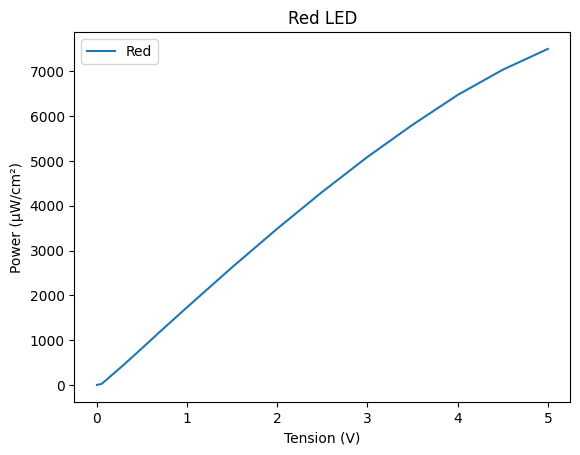

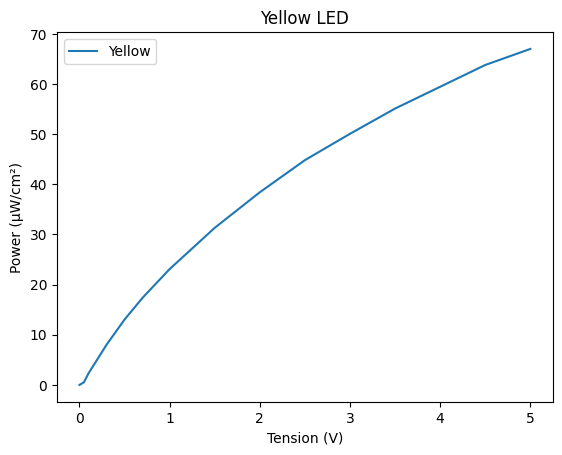

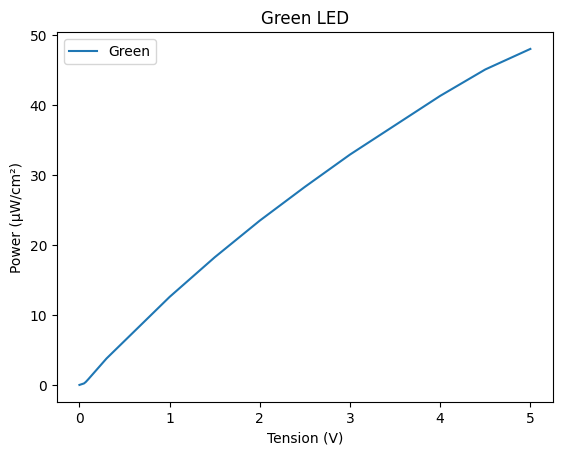

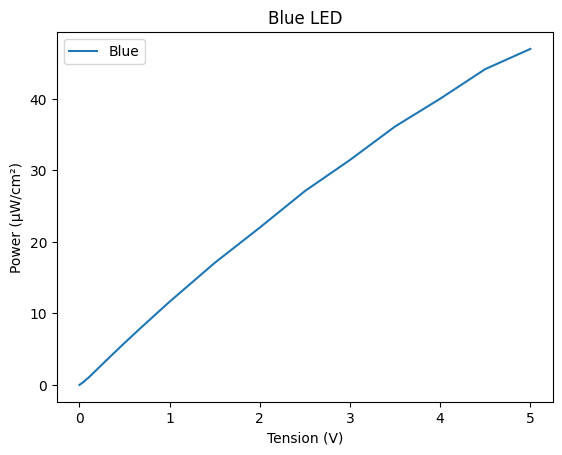

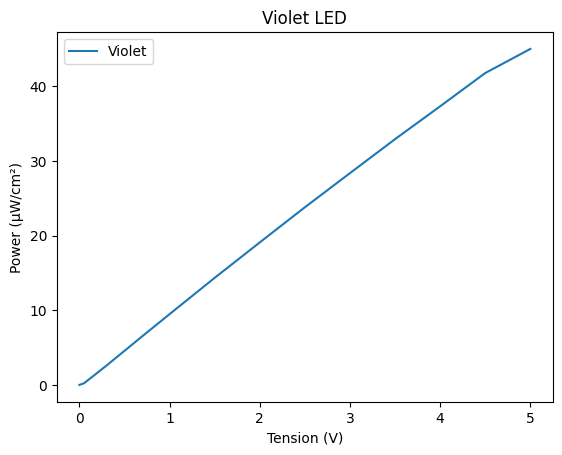

In [5]:
violet_filter = 0.0007448403609977213
yellow_filter = 0.032160625444208

calibration_file = r"./calibration_5_colors_w_MEA_20230403.xlsx"

calibration, _ = charge_calibration(calibration_file, verbose=True)

LED Power Mix:
Violet: 0.38 µW/cm²
Yellow: 2.28 µW/cm²

Ptot with 2 LED Power Values (µW/cm²):
Violet: 0.375
Yellow: 2.284

Isomerisation rate:
Scones: 5.4e+02
Mela: 5.6e+03
Rods: 2.0e+04
Mcones: 1.0e+04
RedOpsin: 1.0e+02


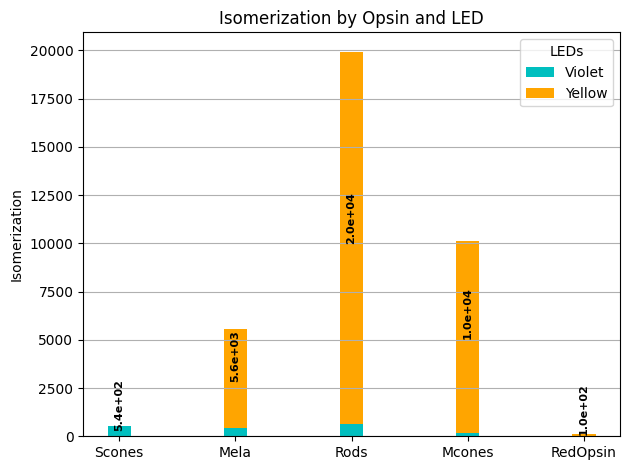

array([0.03150783, 0.12334303])

In [3]:
isomerisation_target = {
    "Scones":5e2,
    "Mcones":1e4,
    'Rods':2e4
}
selected_LEDs = ['Violet', 'Yellow']


Ptot_solution = get_mix_color(isomerisation_target, selected_LEDs = selected_LEDs, ledDATA_path = './IlluminationData.pkl')

plot_isomerisations([Ptot_solution], selected_LEDs = selected_LEDs, colors={'Violet':'c','Yellow':'orange'},ledDATA_path = './IlluminationData.pkl')
plt.show()
plt.close('all')
get_voltages(Ptot_solution, calibration, selected_LEDs)

In [4]:
selected_leds = ["Green", "Yellow", "Red"]
file_path = './Example_PowerList.txt'  # Change this to your file path
compressed = True

output_file_path = file_path.replace('PowerList', 'VoltageList')  # Replace 'PowerList' with 'VoltageList' in the file name
tot=0

with open(file_path, 'r') as file, open(output_file_path, 'w') as output_file:
    output_file.write("{")  # Start of the Arduino-style array
    first_entry=True
    for line in tqdm(file, desc = 'Converting Powers to Voltage : ', total=sum(1 for _ in open(file_path))):
        if not first_entry:
            output_file.write(',')
        first_entry = False
        Ptot = list(map(float, line.split()))

        # Ensure that the number of columns in the line matches the number of selected LEDs
        assert len(Ptot) == len(selected_leds), f"Mismatch: {len(Ptot)} columns in file, but {len(selected_leds)} LEDs selected."

        voltage = get_voltages(Ptot, calibration, selected_leds)  

        # Format as {x,x,x,x,x} for each row
        if compressed:
            formatted_values = "{" + ",".join(map(lambda v: f"{v:d}", float32_to_uint8(voltage))) + "}"
        else:
            formatted_values = "{" + ",".join(map(lambda v: f"{v:f}", voltage.astype(np.float32))) + "}"

        # Write the calculated voltages to the output file in the proper format
        output_file.write(formatted_values)
        tot += 1
    output_file.write("}")  # Start of the Arduino-style array


Converting Powers to Voltage :   0%|          | 0/11 [00:00<?, ?it/s]